Кирбаба Денис, R3238

# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".
Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения, чтобы вычисления были. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [1]:
import numpy as np # linear algebra
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = '/data/flowers'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/MyDrive
#%cp -r $FOLDERNAME ../../
#%cd ../../
%cd /content/drive/MyDrive/data/flowers
#!bash get_datasets.sh
#%cd ../../

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/data/flowers


In [4]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок: 
dataset = ImageFolder('/content/drive/My Drive/data/flowers', transform=prepare_imgs)

In [ ]:
dataset.imgs[2]

In [5]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [6]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

Задаем гиперпараметры для обучения:

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [7]:
batch_size = 32 # размер батча
optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
lr = 0.001 # learning rate

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [8]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3317 1000


Функция для подсчета Accuracy

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [10]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    optimizer: оптимизатор
    epochs: число обучающих эпох (сколько раз пройдемся по всему датасету)
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device) 
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track             

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение:

In [11]:
!nvidia-smi

Wed Dec 15 08:45:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    58W / 149W |   1321MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем обучение на 10 эпох

In [12]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [04:36<00:00,  2.66s/it]


[training] Epoch: 0.00. Loss: 1.42. Accuracy: 34.88% 


100%|██████████| 32/32 [01:20<00:00,  2.50s/it]


[validation] Epoch: 0.00. Loss: 1.71. Accuracy: 34.60% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 1.00. Loss: 1.35. Accuracy: 39.39% 


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


[validation] Epoch: 1.00. Loss: 1.47. Accuracy: 39.95% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 2.00. Loss: 1.27. Accuracy: 44.28% 


100%|██████████| 32/32 [00:10<00:00,  3.03it/s]


[validation] Epoch: 2.00. Loss: 1.34. Accuracy: 45.37% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 3.00. Loss: 1.19. Accuracy: 49.22% 


100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


[validation] Epoch: 3.00. Loss: 1.27. Accuracy: 48.28% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 4.00. Loss: 1.10. Accuracy: 53.98% 


100%|██████████| 32/32 [00:11<00:00,  2.89it/s]


[validation] Epoch: 4.00. Loss: 1.23. Accuracy: 50.84% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 5.00. Loss: 0.99. Accuracy: 58.94% 


100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


[validation] Epoch: 5.00. Loss: 1.25. Accuracy: 52.47% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 6.00. Loss: 0.89. Accuracy: 63.46% 


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


[validation] Epoch: 6.00. Loss: 1.41. Accuracy: 53.23% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 7.00. Loss: 0.80. Accuracy: 67.37% 


100%|██████████| 32/32 [00:10<00:00,  2.96it/s]


[validation] Epoch: 7.00. Loss: 1.57. Accuracy: 53.11% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 8.00. Loss: 0.72. Accuracy: 70.59% 


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


[validation] Epoch: 8.00. Loss: 1.72. Accuracy: 53.69% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 9.00. Loss: 0.66. Accuracy: 73.24% 


100%|██████████| 32/32 [00:10<00:00,  2.93it/s]

[validation] Epoch: 9.00. Loss: 1.83. Accuracy: 54.03% 


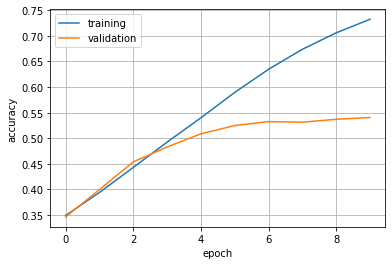

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

# Fine-tuning предобученной модели

Теперь попробуем поработать с предобученной сетью ResNet-18

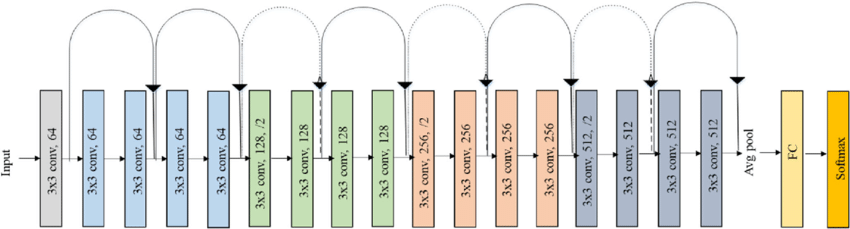

In [14]:
resnet = torchvision.models.resnet18(pretrained=True) # инициализируем модель
resnet

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
def set_parameter_requires_grad(model):
  """
  Функция для заморозки весов модели
  """
  for param in model.parameters():
    param.requires_grad = False
            
set_parameter_requires_grad(resnet)

In [16]:
# Меняем последний слой модели, чтобы он предсказывал 5 классов, а не 1000
# Когда мы заново определяем слой, у него по умолчанию стоит аттрибут requires_grad = True
# То есть этот полносвязный слой будет обучаться
resnet.fc = nn.Linear(512, 5)

In [17]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


Запустим функцию обучения модели. Внимание - необходимо заново задать оптимизатор, чтобы он теперь работал с весами resnet

In [61]:
resnet.to(device)
optimizer = torch.optim.Adam(params = resnet.parameters()) # алгоритм оптимизации
loss_track, accuracy_track = trainval(resnet, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [00:21<00:00,  4.75it/s]


[training] Epoch: 0.00. Loss: 0.33. Accuracy: 89.00% 


100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


[validation] Epoch: 0.00. Loss: 0.34. Accuracy: 88.40% 


100%|██████████| 104/104 [00:21<00:00,  4.82it/s]


[training] Epoch: 1.00. Loss: 0.33. Accuracy: 89.07% 


100%|██████████| 32/32 [00:06<00:00,  4.78it/s]


[validation] Epoch: 1.00. Loss: 0.34. Accuracy: 88.15% 


100%|██████████| 104/104 [00:20<00:00,  4.96it/s]


[training] Epoch: 2.00. Loss: 0.32. Accuracy: 88.98% 


100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


[validation] Epoch: 2.00. Loss: 0.34. Accuracy: 88.03% 


100%|██████████| 104/104 [00:21<00:00,  4.90it/s]


[training] Epoch: 3.00. Loss: 0.31. Accuracy: 89.22% 


100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


[validation] Epoch: 3.00. Loss: 0.33. Accuracy: 87.95% 


100%|██████████| 104/104 [00:21<00:00,  4.92it/s]


[training] Epoch: 4.00. Loss: 0.31. Accuracy: 89.43% 


100%|██████████| 32/32 [00:06<00:00,  4.94it/s]


[validation] Epoch: 4.00. Loss: 0.33. Accuracy: 87.84% 


100%|██████████| 104/104 [00:21<00:00,  4.86it/s]


[training] Epoch: 5.00. Loss: 0.30. Accuracy: 89.61% 


100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


[validation] Epoch: 5.00. Loss: 0.33. Accuracy: 87.90% 


100%|██████████| 104/104 [00:21<00:00,  4.92it/s]


[training] Epoch: 6.00. Loss: 0.30. Accuracy: 89.79% 


100%|██████████| 32/32 [00:06<00:00,  4.90it/s]


[validation] Epoch: 6.00. Loss: 0.33. Accuracy: 87.91% 


100%|██████████| 104/104 [00:20<00:00,  4.98it/s]


[training] Epoch: 7.00. Loss: 0.29. Accuracy: 89.90% 


100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


[validation] Epoch: 7.00. Loss: 0.33. Accuracy: 87.95% 


100%|██████████| 104/104 [00:21<00:00,  4.90it/s]


[training] Epoch: 8.00. Loss: 0.29. Accuracy: 90.02% 


100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


[validation] Epoch: 8.00. Loss: 0.33. Accuracy: 87.99% 


100%|██████████| 104/104 [00:21<00:00,  4.78it/s]


[training] Epoch: 9.00. Loss: 0.29. Accuracy: 90.09% 


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]

[validation] Epoch: 9.00. Loss: 0.33. Accuracy: 88.02% 


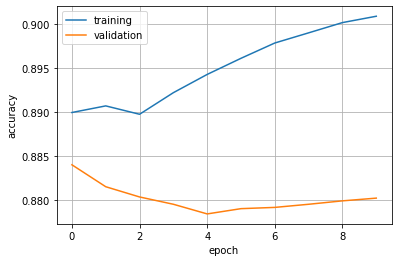

In [62]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

Сохраним веса модели:

In [63]:
weights_fname = '/content/drive/MyDrive/data/flower-resnet.pth'
torch.save(resnet.state_dict(), weights_fname)

# Смотрим результат

И посмотрим как модель предсказывает

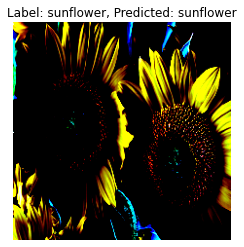

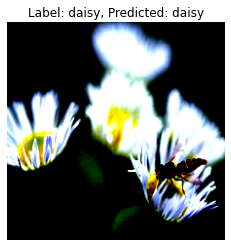

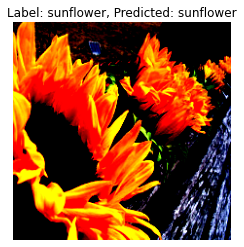

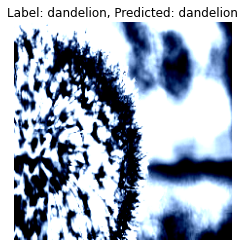

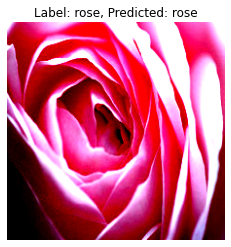

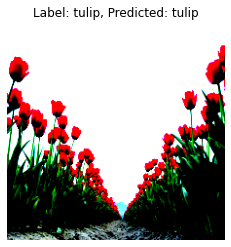

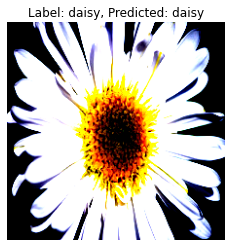

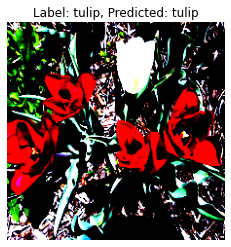

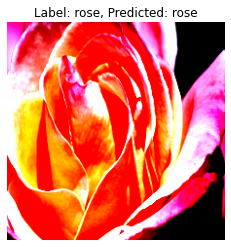

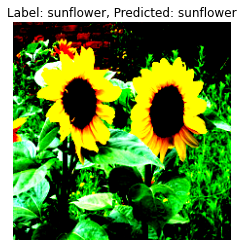

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(20,30):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, resnet)))
  plt.show()
  # print('Label:', dataset.classes[label], ',Predicted:', predict_image(img, resnet))

# Практическое задание 

В пракическом задание необходимо обучить еще одну сверточную архитектуру для задач классификации цветов. 

В выбранной Вами архитектуре также необходимо разобраться с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html), выберите одну и используя transfer learning до-обучите модель на классификацию цветов.




In [53]:
model = torchvision.models.alexnet(pretrained=True) # инициализируем модель
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [54]:
set_parameter_requires_grad(model) # "замораживаем" градиент модели

In [55]:
model.classifier[6] = nn.Linear(4096, 5) # Меняем последний слой модели

In [56]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.6.weight
classifier.6.bias


In [57]:
model.to(device) # Отправляем модель на GPU
optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10) # запускаем обучение

100%|██████████| 104/104 [00:21<00:00,  4.84it/s]


[training] Epoch: 0.00. Loss: 0.55. Accuracy: 79.98% 


100%|██████████| 32/32 [00:06<00:00,  4.87it/s]


[validation] Epoch: 0.00. Loss: 0.41. Accuracy: 83.80% 


100%|██████████| 104/104 [00:21<00:00,  4.93it/s]


[training] Epoch: 1.00. Loss: 0.43. Accuracy: 84.05% 


100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


[validation] Epoch: 1.00. Loss: 0.40. Accuracy: 84.80% 


100%|██████████| 104/104 [00:22<00:00,  4.58it/s]


[training] Epoch: 2.00. Loss: 0.37. Accuracy: 86.21% 


100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


[validation] Epoch: 2.00. Loss: 0.40. Accuracy: 85.00% 


100%|██████████| 104/104 [00:20<00:00,  5.20it/s]


[training] Epoch: 3.00. Loss: 0.33. Accuracy: 87.71% 


100%|██████████| 32/32 [00:06<00:00,  5.15it/s]


[validation] Epoch: 3.00. Loss: 0.40. Accuracy: 85.45% 


100%|██████████| 104/104 [00:20<00:00,  5.18it/s]


[training] Epoch: 4.00. Loss: 0.30. Accuracy: 88.82% 


100%|██████████| 32/32 [00:06<00:00,  5.11it/s]


[validation] Epoch: 4.00. Loss: 0.39. Accuracy: 85.96% 


100%|██████████| 104/104 [00:20<00:00,  5.12it/s]


[training] Epoch: 5.00. Loss: 0.28. Accuracy: 89.68% 


100%|██████████| 32/32 [00:06<00:00,  4.85it/s]


[validation] Epoch: 5.00. Loss: 0.39. Accuracy: 86.33% 


100%|██████████| 104/104 [00:20<00:00,  5.15it/s]


[training] Epoch: 6.00. Loss: 0.26. Accuracy: 90.43% 


100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


[validation] Epoch: 6.00. Loss: 0.39. Accuracy: 86.57% 


100%|██████████| 104/104 [00:20<00:00,  4.95it/s]


[training] Epoch: 7.00. Loss: 0.25. Accuracy: 90.97% 


100%|██████████| 32/32 [00:06<00:00,  5.19it/s]


[validation] Epoch: 7.00. Loss: 0.39. Accuracy: 86.81% 


100%|██████████| 104/104 [00:20<00:00,  5.06it/s]


[training] Epoch: 8.00. Loss: 0.23. Accuracy: 91.43% 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


[validation] Epoch: 8.00. Loss: 0.39. Accuracy: 86.90% 


100%|██████████| 104/104 [00:20<00:00,  5.10it/s]


[training] Epoch: 9.00. Loss: 0.22. Accuracy: 91.87% 


100%|██████████| 32/32 [00:06<00:00,  5.13it/s]

[validation] Epoch: 9.00. Loss: 0.39. Accuracy: 87.03% 


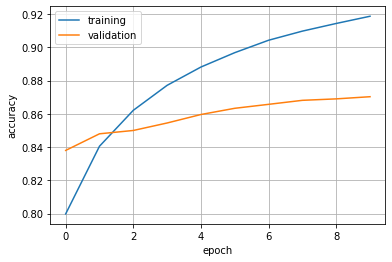

In [58]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

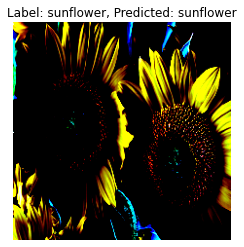

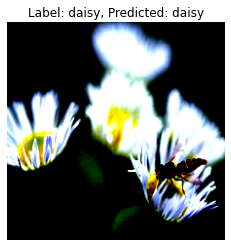

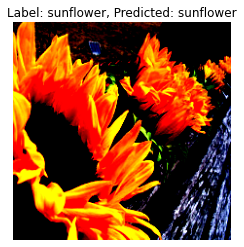

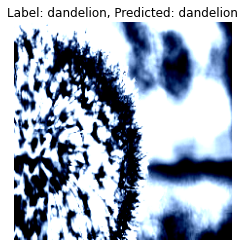

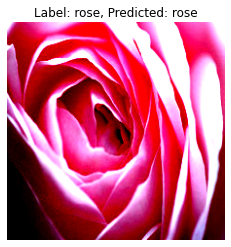

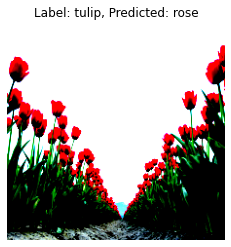

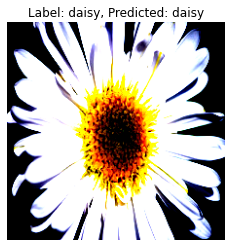

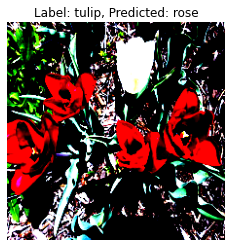

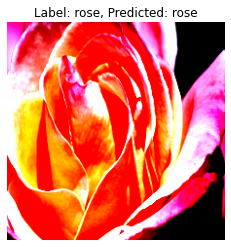

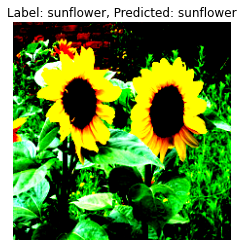

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(20, 30):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label], predict_image(img, model)))
  plt.show()
  # print('Label:', dataset.classes[label], ',Predicted:', predict_image(img, model))

Cохраним веса модели.

In [60]:
weights_fname = '/content/drive/My Drive/data/flower-alexnet.pth'
torch.save(model.state_dict(), weights_fname)

## Выводы

###Выбранная модель
AlexNet

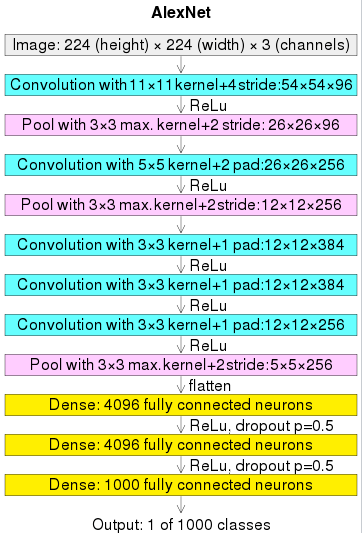

Используется функция активации Relu вместо арктангенса для добавления в модель нелинейности. За счет этого при одинаковой точности метода скорость становится в 6 раз быстрее.

Используется дропаута вместо регуляризации для решения проблемы переобучения. Однако время обучения удваивается с показателем дропаута 0,5.

AlexNet содержит восемь слоев с весовыми коэффициентами. Первые пять из них сверточные, а остальные три — полносвязные. За 1, 2 и 5 сверточным слоем следует max-pool слой (нелинейная понижающая выборка).

Выходные данные пропускаются через функцию потерь softmax.

Relu применяется после каждого сверточного и полносвязного слоя. Дропаут применяется перед первым и вторым полносвязными слоями. Сеть содержит 62,3 миллиона параметров и затрачивает 1,1 миллиарда вычислений при прямом проходе.  Сверточные слои, на которые приходится 6% всех параметров, производят 95% вычислений.

Ядра второго, четвертого и пятого сверточных слоев связаны только с теми картами ядра в предыдущем слое, которые находятся на одном и том же графическом процессоре. Ядра третьего сверточного слоя связаны со всеми картами ядер второго слоя. Нейроны в полносвязных слоях связаны со всеми нейронами предыдущего слоя.

Обучение состоит из 90 эпох, одновременно на двух графических процессорах, что является причиной того, что сеть разделена на две части. Используется стохастический градиентный спуск со скоростью обучения 0,01, импульсом 0,9.

### Сравнение результатов ResNet и AlexNet

AlexNet - Loss: 0.39. Accuracy: 87.03%

ResNet - Loss: 0.33. Accuracy: 88.02%

Количество эпох обучения последнего слоя - 10

### Сверточная и полносвязная нейронные сети

Свёрточные нейронные сети очень похожи на полносвязные нейронные сети: они состоят из нейронов, которые, в свою очередь, содержат изменяемые веса и смещения. Каждый нейрон получает какие-то входные данные, вычисляет скалярное произведение и использует нелинейную функцию активации. Вся сеть по-прежнему представляет собой единственную дифференциируемую функцию оценки: из исходного набора пикселей (изображения) на одном конце до распределения вероятностей принадлежности к определённому классу на другом конце. У этих сетей по-прежнему есть функция потерь на последнем (полносвязном) слое.

Однако, архитектура свёрточных нейронных сетей позволяет учесть определённые свойства входных данных, которые помогают реализовать функцию прямого распространения эффективнее и сильно уменьшают общее количество параметров в сети, так как одно ядро весов используется целиком для всего изображения, вместо того, чтобы делать для каждого пикселя входного изображения свои персональные весовые коэффициенты. Это подталкивает нейросеть при обучении к обобщению демонстрируемой информации, а не попиксельному запоминанию каждой показанной картинки в мириадах весовых коэффициентов, как это делает перцептрон.

Также существует возможность удобного распараллеливания вычислений, а следовательно, возможность реализации алгоритмов работы и обучения сети на графических процессорах.

Сверточная нейронная сеть обладает относительная устойчивостьб к повороту и сдвигу распознаваемого изображения.

### Transfer learning

Transfer learning - это исследовательская проблема в области машинного обучения, которая фокусируется на хранении знаний, полученных при решении одной проблемы, и применении их к другой, но связанной проблеме. Например, знания, полученные при обучении распознаванию автомобилей, могут применяться при попытке распознать грузовики. С практической точки зрения повторное использование или передача информации из ранее изученных задач для изучения новых задач может значительно повысить эффективность и скорость обучения.

В данной работе мы использовали заранее обученные сверточные нейронные сети, которые выполняли задачу классификации изображений по 1000 классам. Мы сохранили веси всех слоев, кроме последнего - там мы изменили количество выходных нейронов с 1000 на 5 для решения конкретно нашей задачи.

### Функция заморозки весов

Функция для заморозки весов модели замораживает модель и таким образом она не будет обучаться. В результате при добавлении к ней нового слоя (по умолчанию он будет иметь флаг True) только он будет обучаться. Это нам необходимо, так как мы импортируем предобученную модель у которой классификация по 1000 классов, а мы хотим классифицировать по 5 классам. 